## Импорт библиотек

In [1]:
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
import scipy.stats as sts
import pandas as pd
import itertools
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
from itertools import product 

%matplotlib inline

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Определение параметров проекта

In [2]:
start_date = '2014.01'
end_date = '2016.05'
target_cell = 1231

In [3]:
def generate_urls(start, end=None):
    if end == None: end = start
    period = pd.DatetimeIndex(start=pd.Timestamp(start), end=pd.Timestamp(end), freq = 'MS')
    dates = zip(period.year, period.month)
    base_url = 'Pivots/pivot_yellow_tripdata_'
    raw_data_urls = [(y, m, base_url+"{}-{:0>2}.csv".format(y, m)) for y, m in dates]
    return raw_data_urls
urls = generate_urls(start_date, end_date)


## Импорт данных

In [4]:
vals = np.empty(0)
for y, m, url in urls: 
    mid = pd.read_csv(url, index_col=0).loc[1231,:].values
    vals = np.hstack((vals, mid))
#data = pd.DataFrame(vals, index=pd.DatetimeIndex(start=start_date, end=end_date, freq = 'H'))

data = pd.DataFrame(vals, 
        index = pd.DatetimeIndex(start=start_date, end='2016.06', closed='left',freq = 'H'), 
        dtype = 'int16')
data.columns = ['Trips']
data = data.iloc[-3648:,:]
print(data.shape)
data.head()


(3648, 1)


,Trips
2016-01-01 00:00:00,938
2016-01-01 01:00:00,830
2016-01-01 02:00:00,739
2016-01-01 03:00:00,771
2016-01-01 04:00:00,560


In [5]:
#data = data[data.index >=pd.to_datetime('2016.01')]
#data.tail()

## Визуальный анализ ряда

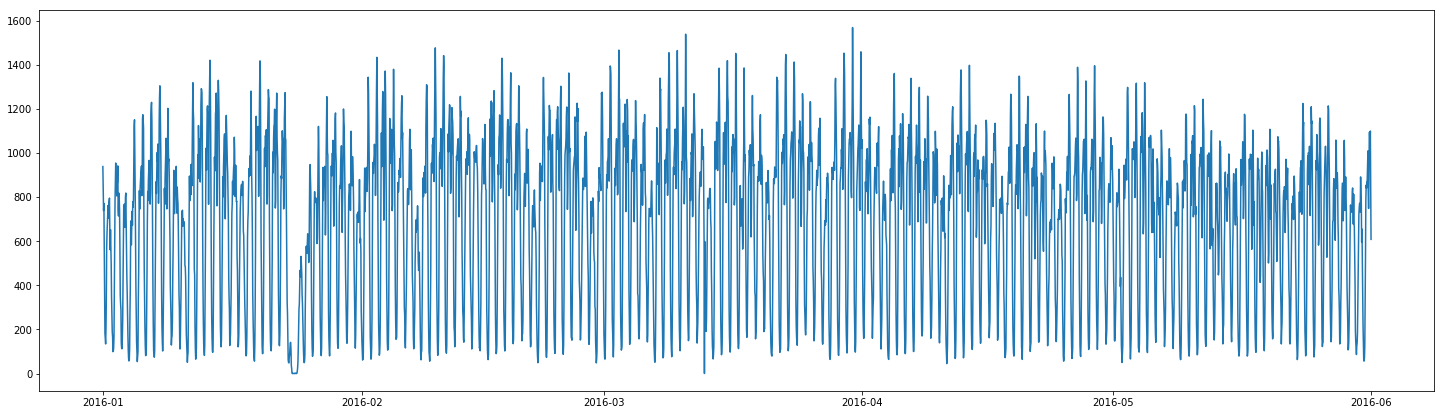

In [6]:
plt.figure(figsize=(25,7))
plt.plot(data)

Похоже, что в данных есть некоторый понижающийся тренд, однако дисперсия постепенно уменьшается. Видна недельная сезонность

Критерий Дики-Фуллера: p=0.000000


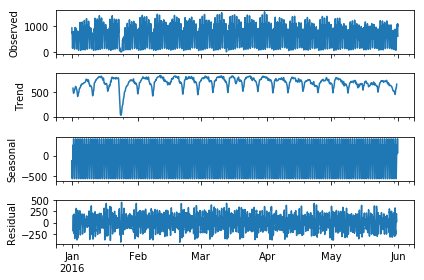

In [7]:
plt.figure(figsize=(20,20))
#figure(figsize=(20,20))
sm.tsa.seasonal_decompose(data.Trips).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Trips)[1]);

## Подбор регрессионных признаков

In [8]:
T = np.array(range(len(data)))
i = 3
def calc_sin(i, period = 'week'):
    if period == 'week':
        return np.sin(T * 2 * np.pi * i /168)
    else:
        return np.sin(T * 2 * np.pi * i /8766)
def calc_cos(i, period = 'week'):
    if period == 'week':
        return np.cos(T * 2 * np.pi * i /168)
    else:
        return np.cos(T * 2 * np.pi * i /8766)

In [9]:
def generate_features(data, k_week_sin,k_week_cos, k_year_sin = None, k_year_cos = None):
    df = data.copy()
    for i in range(1,k_week_sin+1):
        df['sin_week_'+str(i)] = calc_sin(i, 'week')
    for i in range(1,k_week_cos+1):
        df['cos_week_'+str(i)] = calc_cos(i, 'week')
    if k_year_sin:
        for i in range(1,k_year_sin+1):
            df['sin_year_'+str(i)] = calc_sin(i, 'year')
    if k_year_cos:
        for i in range(1,k_year_cos+1):
            df['cos_year_'+str(i)] = calc_cos(i, 'year')
    return df

In [63]:
kw_s = np.hstack((range(1,11), [15,20,25]))
kw_c = np.hstack((range(1,11), [15,20,25]))
# Параметры для вычисления годовой сезонности
#ky_s = np.hstack((range(10), [15,20,25]))
#ky_c = np.hstack((range(10), [15,20,25]))
params = list(product(kw_s,kw_c))#,ky_s,ky_c))
print(len(params))

169


In [19]:
# Построим несколько графиков прогнозов для разных сочетаний количества сезоных признаков и отрисуем последние 500 точек в данныз
from sklearn.linear_model import LinearRegression, Ridge
model = Ridge()
i=1
MSEs = []
plt.figure(figsize=(15,200))
for kws, kwc in params:
    #print(kws, kwc)
    df = generate_features(data, kws, kwc)
    X, y = df.drop('Trips', axis=1).values, df.Trips.values
    df['preds'] = model.fit(X,y).predict(X)
    mean_sq_error = sum(np.sqrt((df.preds-df.Trips)**2))/len(df)
    MSEs.append(mean_sq_error)
    #plt.subplot(len(params),1,i)
    #plt.plot(df.Trips[-500:])
    #plt.plot(df.preds[-500:], alpha = 0.5)
    #plt.title('kw = {}, ky = {}, MSE = {}'.format(kw, ky, mean_sq_error))
    i+=1

In [64]:
n_feats = [x + y for x,y in params]
res = pd.DataFrame({'params':params, 'n_features':n_feats,'MSE':MSEs})
res['diff'] = res.MSE.diff()
res.sort_values('MSE', ascending=True)

,MSE,n_features,params,diff
168,87.133173,50,"(25, 25)",-2.705314
155,87.515233,45,"(20, 25)",-2.347261
142,89.183997,40,"(15, 25)",-2.338133
167,89.838487,45,"(25, 20)",-0.681792
154,89.862494,40,"(20, 20)",-0.799345
166,90.520279,40,"(25, 15)",-30.583788
153,90.661839,35,"(20, 15)",-30.374737
141,91.522130,35,"(15, 20)",-0.720226
140,92.242356,30,"(15, 15)",-28.624963
139,120.867319,25,"(15, 10)",-0.339386


Далее будем использовать модель с 15 синусными и 15 косинусными регресиоными признаками, как обеспечивающюю достаточно высокое качество модели, и при этом не слишком сложную

Text(0.5,1,'Прогнозы количества поездок от ESB по историческим данным за январь 2014')

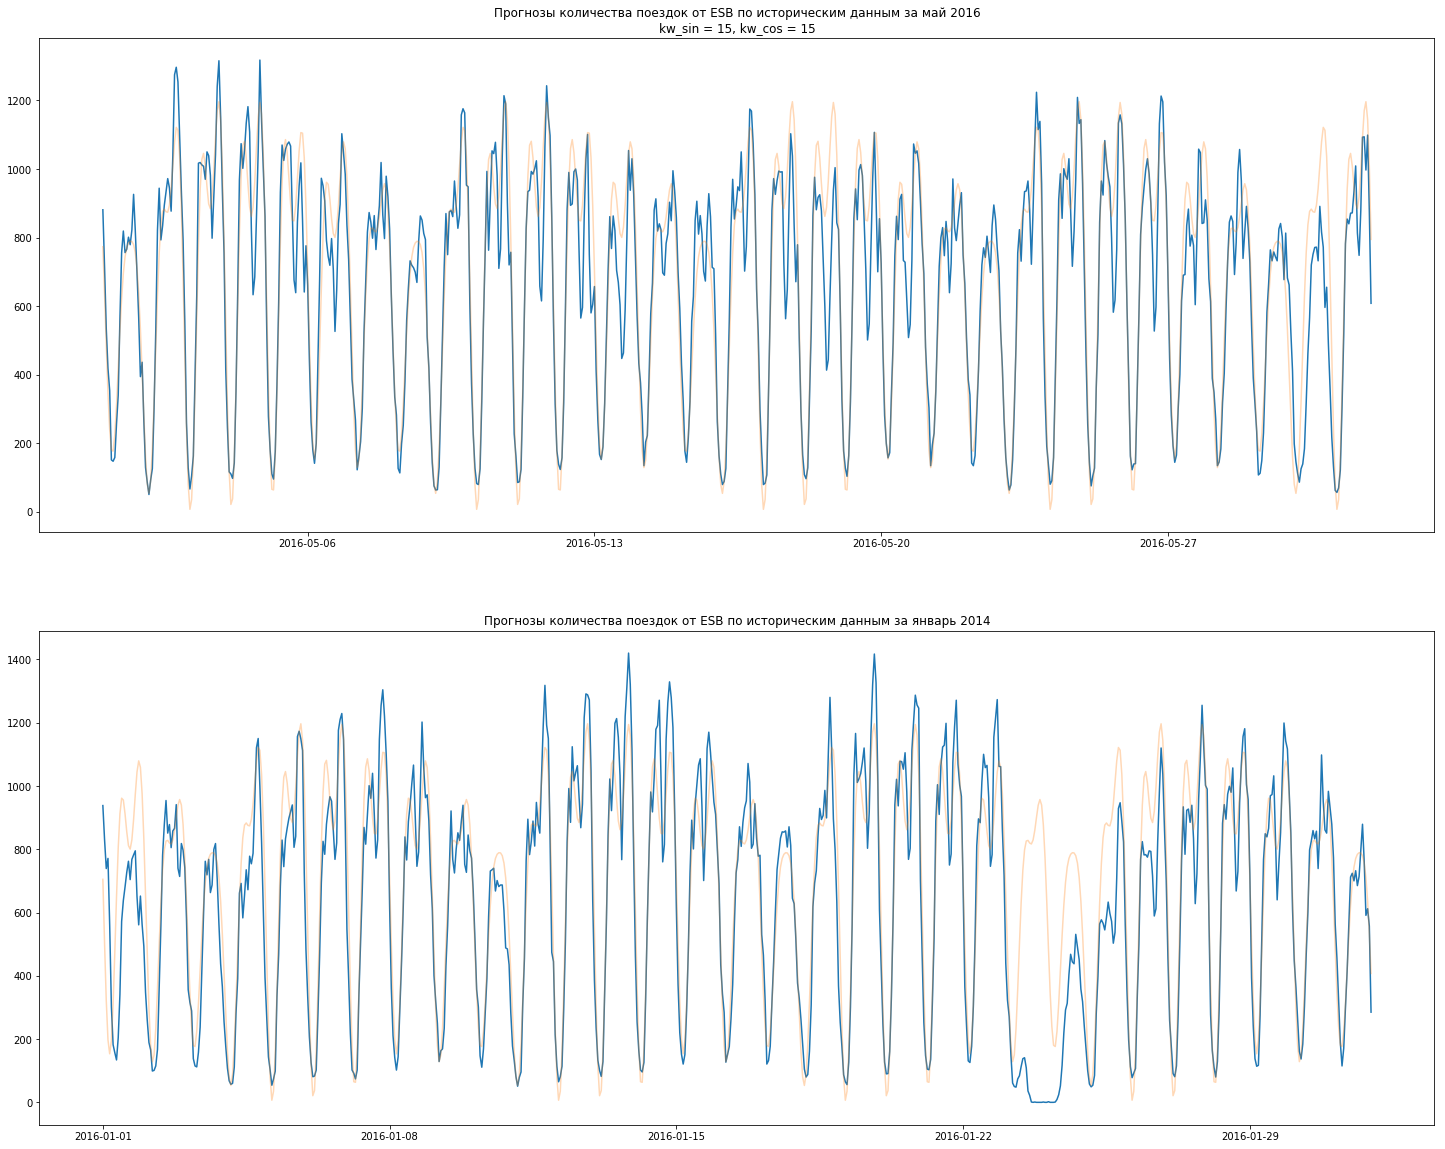

In [25]:
plt.figure(figsize=(25,20))
df = generate_features(data, 15, 15)
X, y = df.drop('Trips', axis=1).values, df.Trips.values
df['preds'] = model.fit(X,y).predict(X)
mean_sq_error = sum(np.sqrt((df.preds-df.Trips)**2))/len(df)
residuals = df.preds - df.Trips
# Визуализируем первый и последний месяц в данных
plt.subplot(2,1,1)
plt.plot(df.Trips[-744:])
plt.plot(df.preds[-744:], alpha = 0.3)
plt.title('Прогнозы количества поездок от ESB по историческим данным за май 2016\nkw_sin = {}, kw_cos = {}'.format(15, 15))
plt.subplot(2,1,2)
plt.plot(df.Trips[:744])
plt.plot(df.preds[:744], alpha = 0.3)
plt.title('Прогнозы количества поездок от ESB по историческим данным за январь 2014')


In [43]:
# На графике января 2016 года виден существенный провал. Попробуем восстановить данные с помощью 
# прогнозов регрессис
ind = df[df.Trips <= 30].index
df.Trips[df.Trips <= 30] = df.preds[ind]

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Series([], Freq: H, Name: Trips, dtype: float64)

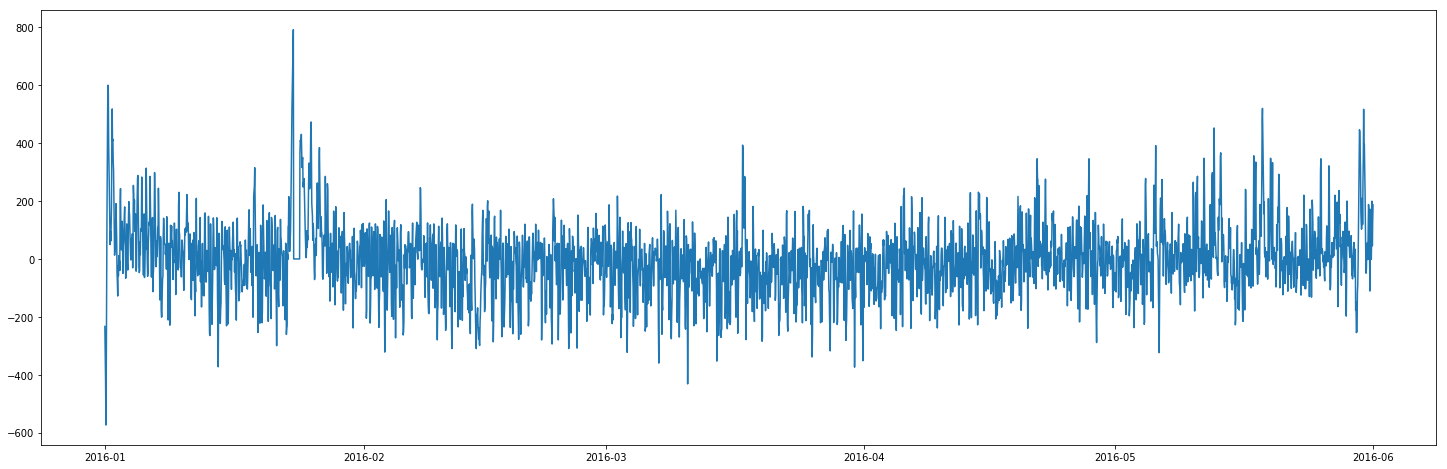

In [45]:
residuals = df.preds - df.Trips
plt.figure(figsize=(25,8))
plt.plot(residuals)#[-500:])

## Преобразования остатков

In [50]:
plt.figure(figsize=(25,40))
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residuals)[1])

Критерий Дики-Фуллера: p=0.000000


Критерий Дики-Фуллера уверенно отвергает гипотезу о нестационарности ряда остатков, однако мы все равно наблюдаем наличие тренда и сезонности, а дисперсия остатков выглядит непостоянной.

Попробуем продифференцировать ряд

-0.40231534940480607
Критерий Дики-Фуллера: p=0.000000


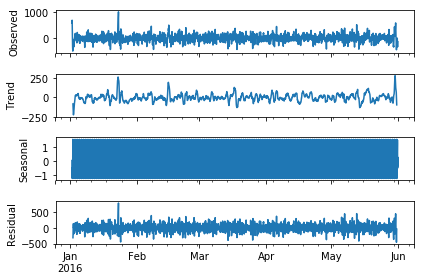

In [51]:
# Произведем сезонное дифференцирование ряда 
plt.figure(figsize=(25,5))

residuals_diff_1 = residuals - residuals.shift(24)
print(residuals_diff_1.mean())
sm.tsa.seasonal_decompose(residuals_diff_1[24:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residuals_diff_1[24:])[1])

-0.19614903747933995
Критерий Дики-Фуллера: p=0.000000


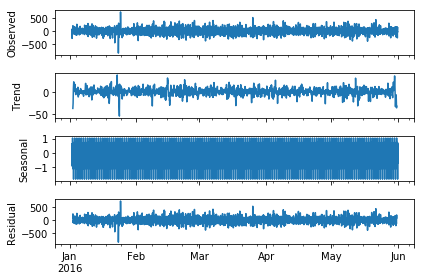

In [52]:
# И еще одно обычное
residuals_diff_1_1 = residuals_diff_1 - residuals_diff_1.shift(1)
print(residuals_diff_1_1.mean())
sm.tsa.seasonal_decompose(residuals_diff_1_1[25:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residuals_diff_1_1[25:])[1])

0.0181831138594092
Критерий Дики-Фуллера: p=0.000000


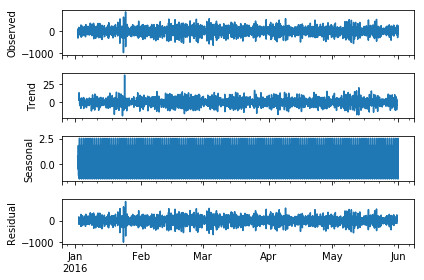

In [53]:
# И еще одно
residuals_diff_1_2 = residuals_diff_1_1 - residuals_diff_1_1.shift(1)
print(residuals_diff_1_2.mean())
sm.tsa.seasonal_decompose(residuals_diff_1_2[26:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residuals_diff_1_2[26:])[1])

После двукратного дифференцирования почти удалось избавиться от тренда и выбросов, а сам ряд остатков сосредоточен около нуля.
D = 1, d = 1

## Подбор параметров ARIMA

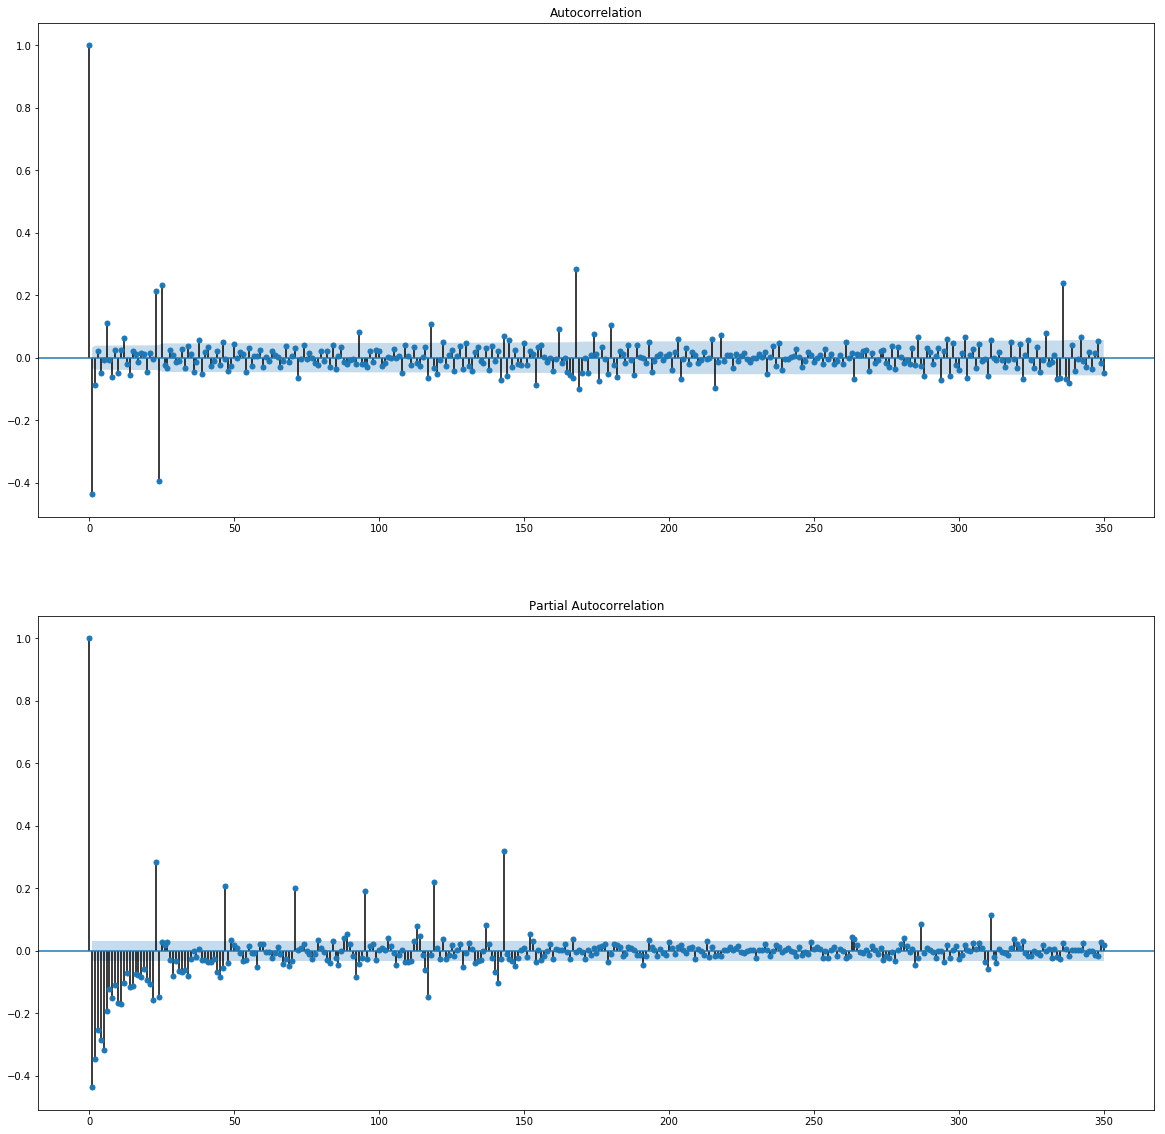

In [54]:
## Посмотрим на автокорреляционные функции для ряда остатков
plt.figure(figsize=(20,20))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(residuals_diff_1_2[26:].values.squeeze(), lags=7*50, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(residuals_diff_1_2[26:].values.squeeze(), lags=7*50, ax=ax)
plt.show()

На почасовом графике очень трудно выбрать начальные приближения параметров, так как все корреляции показаны как значимые. Однако видна четкая суточная сезонность - значения ряда сильно коррелируют со значениями с лагами, кратными 24, причем самая высокая корреляция - с лагами одинаковых дней и часов.

Так как мы оцениваем почасовой график, то визуально будет очень сложно оценить график за год, поэтому для первых приближений воспользуемся данными за 1-2 недели и выберем начальные приближения по ним:
* Q = 14 (336/24)
* q = 25
* P = 6 (146/24) - на графике видно, что лаг 168, соответствующий 7-му дню, уже имеет очень слабую коррелцию
* p = 146

In [66]:
Qs = [0,1,2]
qs = [0,1]#[0, 10, 20,25]
Ps = range(2)#range(1,7)
ps = range(2)#[0,50,100,146]
params = list(product(ps,qs,Ps,Qs))
len(params), params[:10]

(24,
 [(0, 0, 0, 0),
  (0, 0, 0, 1),
  (0, 0, 0, 2),
  (0, 0, 1, 0),
  (0, 0, 1, 1),
  (0, 0, 1, 2),
  (0, 1, 0, 0),
  (0, 1, 0, 1),
  (0, 1, 0, 2),
  (0, 1, 1, 0)])

In [60]:
df.shape
#df.iloc[:,range(1,61)].head()

(3648, 34)

In [65]:
nfeats = 15 + 15 # количество регрессионных признков
exog = df.iloc[:,range(1,nfeats+1)].values
#data.Trips
exog.shape

(3648, 30)

In [72]:
%%time
d=2
D=1
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in params:
    print(param)
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.Trips[-3648:], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24),
                                        exog = residuals).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(0, 0, 0, 0)
wrong parameters: (0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 0, 2)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 1, 2)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 0, 2)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 1, 2)
(1, 0, 0, 0)
(1, 0, 0, 1)
(1, 0, 0, 2)
(1, 0, 1, 0)
(1, 0, 1, 1)
(1, 0, 1, 2)
(1, 1, 0, 0)
(1, 1, 0, 1)
(1, 1, 0, 2)
(1, 1, 1, 0)
(1, 1, 1, 1)
(1, 1, 1, 2)
Wall time: 41min 1s


In [73]:
best_param, best_aic

((1, 1, 0, 2), 35852.253498502636)

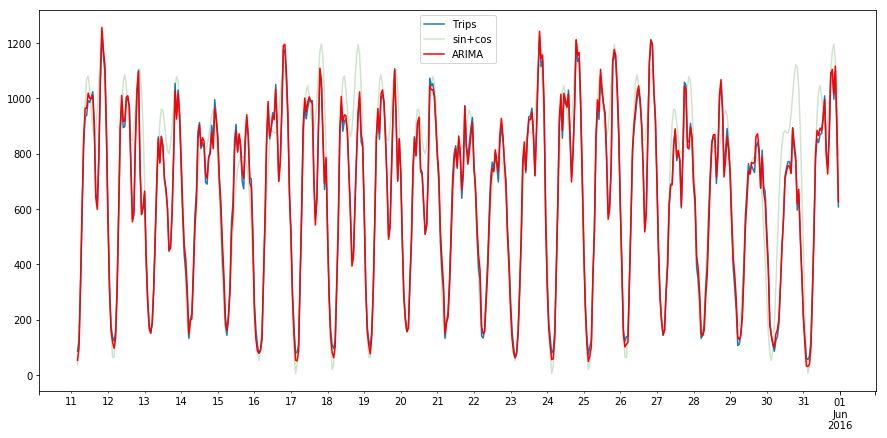

In [80]:
data['model'] = best_model.fittedvalues
plt.figure(figsize=(15,7))
data.Trips[-500:].plot()
df.preds[-500:].plot(color = 'g', label = 'sin+cos', alpha = 0.2)
data.model[-500:].plot(color='r', label = 'ARIMA')
plt.legend()

Критерий Стьюдента: p=0.953099
Критерий Дики-Фуллера: p=0.000000


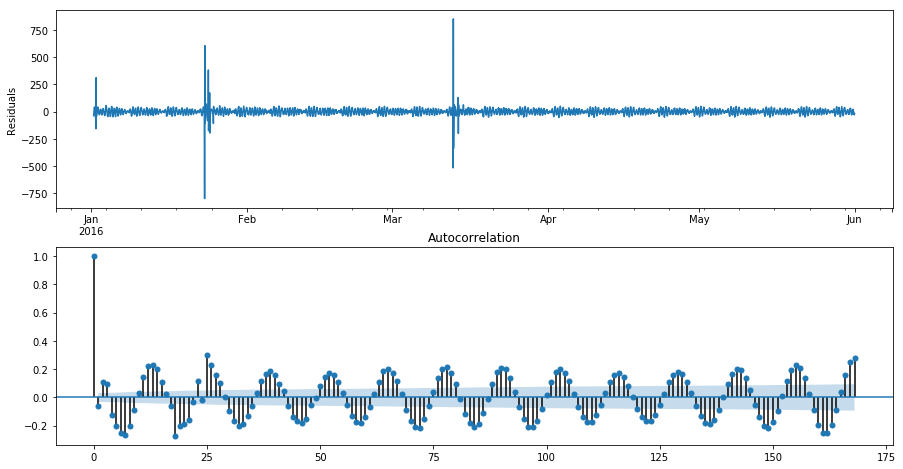

In [75]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % sts.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])


Судя по остаткам модели наиболее сильные отклонения модели от фактических значений произошли в конце января и примерно в середине марта. Выведем графики этих месяцев, чтобы подробнее изучить данные и прогнозы

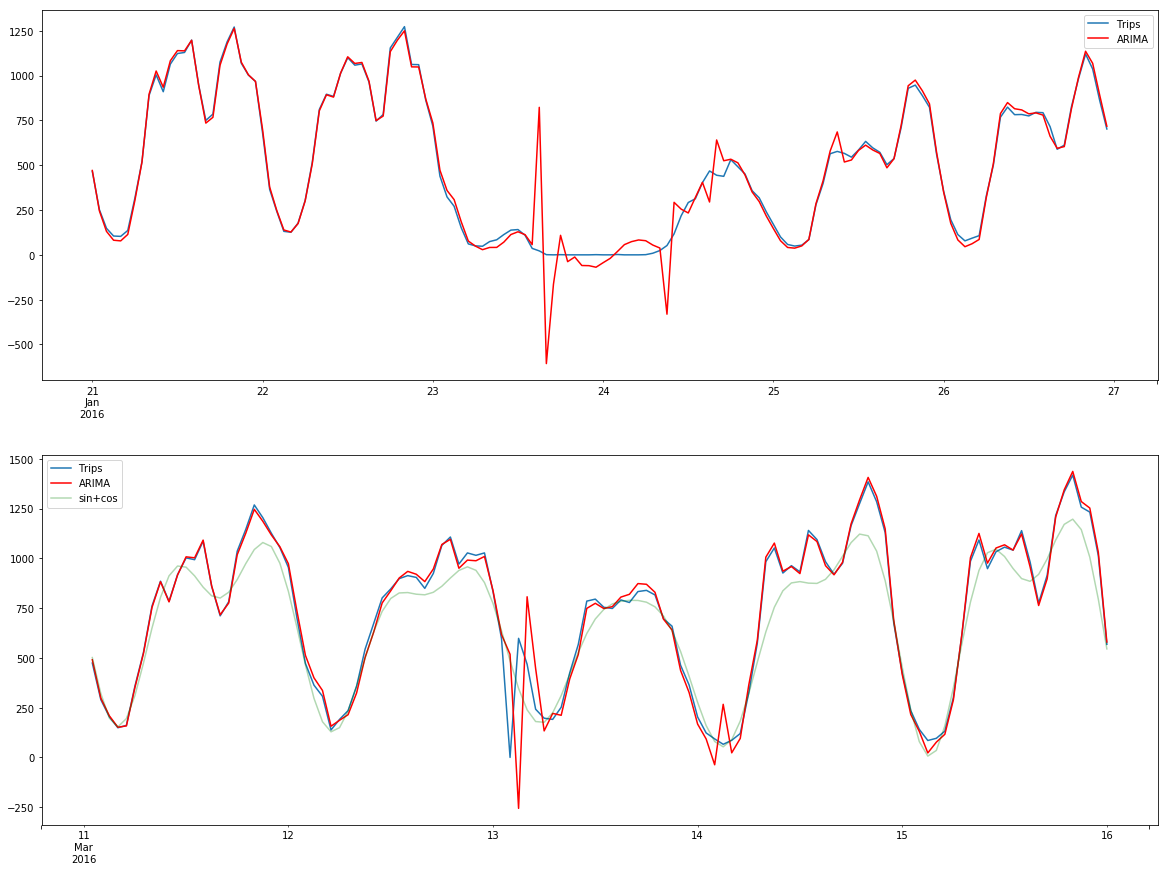

In [97]:
plt.figure(figsize=(20,15))
# График за январь
start = 0 + 20*24
end = 0 + 26*24
plt.subplot(211)
data.Trips[start:end].plot()
data.model[start:end].plot(color='r', label = 'ARIMA')
plt.legend()
# График за март
start = 1441 + 10*24
end = 1441 + 15*24
plt.subplot(212)
data.Trips[start:end].plot()
data.model[start:end].plot(color='r', label = 'ARIMA')
df.preds[start:end].plot(color = 'g', label = 'sin+cos', alpha = 0.3)
plt.legend()

В данном случае модель показала неудачные результаты в периоды аномально низкого количества поездок, причем эти провалы выглядят как отсутствие данных, так как фактическое количество поездок обращается в 0. 

Настроить модель на такие аномалии нельзя, но можно будет поставить ограничение на прогнозы, чтобы минимальное значение было равно 0